# Stage 3: Classification

## Basic ideas: 

1. Find/generate proper features
2. Run different classification algorithms
3. Evaluate result

Will use conference names as initial labels and classify based on this. Chose KDD(dataset 09) and NIPS(dataset 19). 

## Init and input

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA
from sklearn import manifold
from pattern.en.wordlist import BASIC
from pattern.en import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

/home/yimeng/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import xgboost as xgb

In [4]:
from sklearn import svm

In [5]:
fpaper = 'paper_dataset.txt'
dpaper = pd.read_csv(fpaper, sep='\t')
titles = np.array(dpaper['title'])
abstracts = np.array(dpaper['abstract'])
indices = np.array(dpaper['index_keys'])

fpaper2 = 'paper_dataset2.txt'
dpaper2 = pd.read_csv(fpaper2, sep='\t')
titles2 = np.array(dpaper2['title'])
abstracts2 = np.array(dpaper2['abstract'])
indices2 = np.array(dpaper2['author_keys'])

fpaper3 = 'paper_dataset3.txt'
dpaper3 = pd.read_csv(fpaper3, sep='\t')
titles3 = np.array(dpaper3['title'])
abstracts3 = np.array(dpaper3['abstract'])
indices3 = np.array(dpaper3['index_keys'])

# Create labels for data sets
labels = np.zeros(np.size(indices))
labels2 = np.ones(np.size(indices2))
labels3 = 2*np.ones(np.size(indices3))

## Preprocessing
Preprocessing consists of following parts: 
1. Remove punctuations
2. Tokenization
3. Remove stopwords
4. Lemmatize
5. Do above for all abstracts and titles. Construct new vector of words. 

In [6]:
stops = set(stopwords.words("english"))
lmtzr = WordNetLemmatizer()

def pre_processing_a_sentence(sentence, method):
    if method == 'BoW':
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower().split()
        # Remove stop words
        words_in_sentence = [w for w in words_in_sentence if not w in stops]
        ## Wordlists
        # words_in_sentence = [w for w in words_in_sentence if not w in BASIC]
        # Lemmatize
        words_lemmatized_in_sentence = []
        for w in words_in_sentence:
            w = lmtzr.lemmatize(w, pos = 'v')
            words_lemmatized_in_sentence.append(w)
    else:
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower()
        
        n2 = ngrams(words_in_sentence, n=2, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n2=[]
        for phrase_words in n2:
            joined_n2.append('-'.join(phrase_words))
            
        n3 = ngrams(words_in_sentence, n=3, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n3=[]
        for phrase_words in n3:
            joined_n3.append('-'.join(phrase_words))
            
        words_lemmatized_in_sentence = []
        words_lemmatized_in_sentence.extend(joined_n2)
        words_lemmatized_in_sentence.extend(joined_n3)
        
    return words_lemmatized_in_sentence

def pre_processing(sentence_array, method):
    num = sentence_array.size
    words_array_clean = []
    
    # delete "NaN" (if there's any)
    sentence_array_nan_indices = pd.isnull(sentence_array)
    for i in xrange( 0, num ):
        if(sentence_array_nan_indices[i] == False):
            words_array_clean.append( str(pre_processing_a_sentence( sentence_array[i], method ) ) )
        else:
            words_array_clean.append( ' ' )
            
    return words_array_clean

In [7]:
w_abstract = pre_processing(abstracts, 'ngrams')
w_title = pre_processing(titles, 'BoW')
w_index = pre_processing(indices, 'BoW')

w_abstract2 = pre_processing(abstracts2, 'ngrams')
w_title2 = pre_processing(titles2, 'BoW')
w_index2 = pre_processing(indices2, 'BoW')

w_abstract3 = pre_processing(abstracts3, 'ngrams')
w_title3 = pre_processing(titles3, 'BoW')
w_index3 = pre_processing(indices3, 'BoW')

## Feature generation

### BoW/ngrams

In [8]:
vectorizer_abstract = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5500) # 600*150=90000 used to be 6000
vectorizer_title = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) # 600*10 = 6000
vectorizer_index = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 800) # 600*10 = 6000

def feature_generation(word_array, vectorizer):
    feature_array = vectorizer.fit_transform(word_array).toarray()
    feature_list = vectorizer.get_feature_names()
    return feature_array, feature_list

In [9]:
feature_array_title, feature_list_title = feature_generation(w_title, vectorizer_title)
feature_array_abstract, feature_list_abstract = feature_generation(w_abstract, vectorizer_abstract)
feature_array_index, feature_list_index = feature_generation(w_index, vectorizer_index)

feature_array_title2, feature_list_title2 = feature_generation(w_title2, vectorizer_title)
feature_array_abstract2, feature_list_abstract2 = feature_generation(w_abstract2, vectorizer_abstract)
feature_array_index2, feature_list_index2 = feature_generation(w_index2, vectorizer_index)

feature_array_title3, feature_list_title3 = feature_generation(w_title3, vectorizer_title)
feature_array_abstract3, feature_list_abstract3 = feature_generation(w_abstract3, vectorizer_abstract)
feature_array_index3, feature_list_index3 = feature_generation(w_index3, vectorizer_index)

### Attach variables

In [10]:
def attach_array(a1, a2):
    return np.concatenate((a1, a2), axis=0)

In [11]:
#feature_array_title_attached = attach_array(feature_array_title, feature_array_title2)
#feature_array_index_attached = attach_array(feature_array_index, feature_array_index2)
#feature_array_abstract_attached = attach_array(feature_array_abstract, feature_array_abstract2)
#labels_attached = np.append(labels,labels2)

In [12]:
feature_array_title_attached = attach_array(attach_array(feature_array_title, feature_array_title2),feature_array_title3)
feature_array_index_attached = attach_array(attach_array(feature_array_index, feature_array_index2),feature_array_index3)
feature_array_abstract_attached = attach_array(attach_array(feature_array_abstract, feature_array_abstract2),feature_array_abstract3)
labels_attached = np.append(np.append(labels,labels2),labels3)

### PCA feature selection

In [13]:
def PCA_analysis(feature_array, n):# find first n highest variances
    pca = PCA(n_components = n) 
    pca.fit(feature_array)
    feature_array_pca = pca.transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(pca.explained_variance_ratio_, 'ro')
    plt.ylabel('Percentage of variances')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.subplot(212)
    plt.plot(pca.singular_values_, 'bo')
    plt.ylabel('Singular values')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.show()
    
    return feature_array_pca

/home/yimeng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


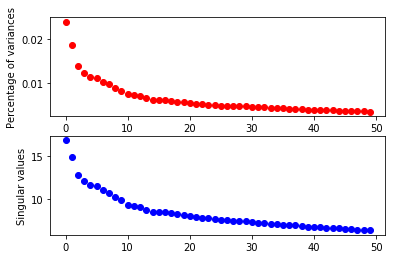

In [14]:
feature_array_title_pca = PCA_analysis(feature_array_title_attached, 50)

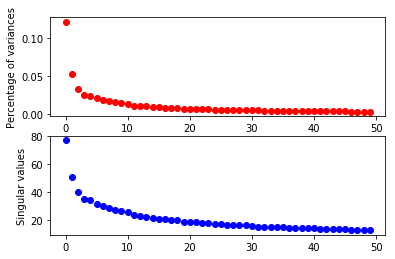

In [16]:
feature_array_index_pca = PCA_analysis(feature_array_index_attached, 50)

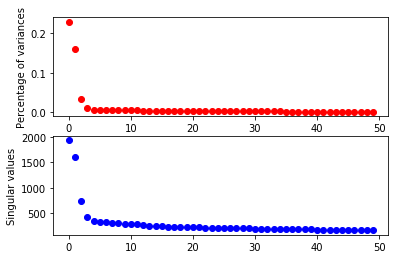

In [17]:
feature_array_abstract_pca = PCA_analysis(feature_array_abstract_attached, 50)

### Evaluation of selected features

In [18]:
def scatter_visualization_2D(data_array):
    plt.scatter(data_array[:,0], data_array[:,1], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def scatter_visualization_3D(data_array):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_array[:,0], data_array[:,1], data_array[:,2], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()
    
def scatter_visualization_2D_with_labels(data_array, labels):
    colors = [int(i%23) for i in labels]
    plt.scatter(data_array[:,0], data_array[:,1], c=colors, s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def scatter_visualization_3D_with_labels(data_array, labels):
    fig = plt.figure()
    colors = [int(i%23) for i in labels]
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_array[:,0], data_array[:,1], data_array[:,2], c=colors, s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()

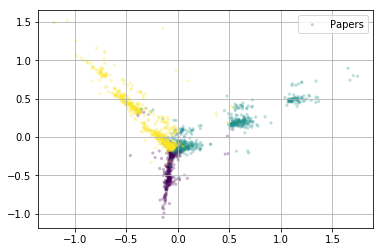

In [19]:
scatter_visualization_2D_with_labels(feature_array_title_pca, labels_attached)

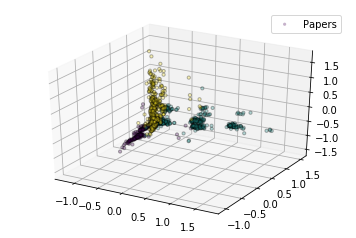

In [20]:
scatter_visualization_3D_with_labels(feature_array_title_pca, labels_attached)

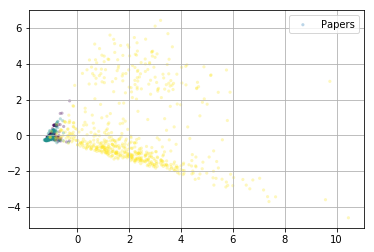

In [21]:
scatter_visualization_2D_with_labels(feature_array_index_pca, labels_attached)

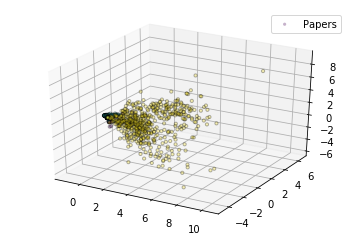

In [22]:
scatter_visualization_3D_with_labels(feature_array_index_pca, labels_attached)

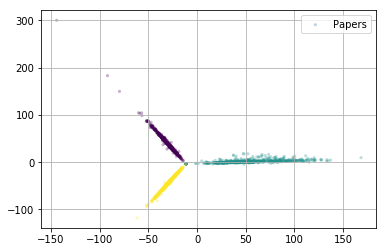

In [23]:
scatter_visualization_2D_with_labels(feature_array_abstract_pca, labels_attached)

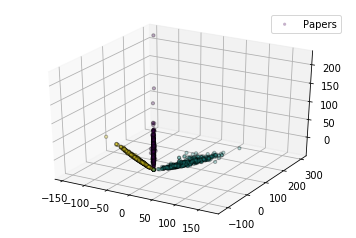

In [24]:
scatter_visualization_3D_with_labels(feature_array_abstract_pca, labels_attached)

### Conclusion on BoW feature generation & selection
1. This time abstracts give best discrimination. 
2. One possible reason: it's more distinguishable in abstracts because a lot of terminologies in specific fields will appear more. Titles mostly contains something relatively more general. 

## Classification using SVM
As the boundries are already clear on the scatter plot, we will just use SVM to do this. 

First let's create cross validation data. 

In [25]:
feature_array_abstract_pca_selected = feature_array_abstract_pca[:,:10]


In [118]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(feature_array_abstract_pca_selected, labels_attached, 
                                                                 test_size=0.3, random_state = 0)

In [27]:
# clf = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5) #98.9
# clf = AdaBoostClassifier(n_estimators=350, learning_rate=0.03) #99.8
# clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.03, nthread=4, subsample=0.95, colsample_bytree=0.85, seed=4242)  
# 99.6
# clf = RandomForestClassifier(
#        criterion = 'entropy', #gini
#        n_estimators=100, 
#        max_features=5,
#        max_depth = 25,   
#        min_samples_split = 20,
#        min_samples_leaf = 1,
#        n_jobs = 4,
#        random_state = 0
#        )
# 99.4
clf = svm.SVC() # 79.5. Actually linear SVM works better

In [28]:
clf.fit(xTrain, yTrain)
print clf.score(xTrain, yTrain)
print clf.score(xTest, yTest)

0.996967399545
0.795053003534


### Try to visualize SVM result

In [127]:
xTrain1, xPlot, yTrain1, yPlot = cross_validation.train_test_split(feature_array_abstract_pca_selected[:,0:2], labels_attached, 
                                                                 test_size=0.3, random_state = 0)

In [97]:
clf = svm.LinearSVC()
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

0.997347480106
0.992042440318


In [106]:

def make_meshgrid(x, y, h=.5):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
#    Z = clf.predict(xPlot[1:-1,:])
    Z = clf.predict(np.transpose([xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [114]:
def my_plot(xPlot, yPlot):
    X0, X1 = xPlot[:,0], xPlot[:,1]
    xx, yy = make_meshgrid(X0, X1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    fig = plt.figure
    plotArray = np.transpose([xx.ravel(), yy.ravel()]);
    for cor in range(plotArray.shape[1]):
        colors = [int(i%23) for i in Z]
        plt.scatter(plotArray[:,0], plotArray[:,1], c=colors, s=10, label='Papers',
                   alpha=0.3, edgecolors='none')
        
    plt.scatter(X0, X1, c=yPlot, cmap=plt.cm.coolwarm, s=20, edgecolors='k') 
    plt.show()

In [136]:
xPlot.shape

(566, 2)

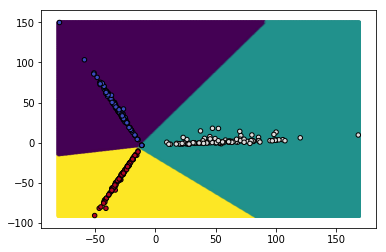

In [115]:
my_plot(xPlot, yPlot)

In [116]:
def official_plot(xPlot, yPlot):
    X0, X1 = xPlot[:,0], xPlot[:,1]
    xx, yy = make_meshgrid(X0, X1)
    
    fig = plt.figure
    
    plot_contours(plt, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X0, X1, c=yPlot, cmap=plt.cm.coolwarm, s=20, edgecolors='k')  
    plt.show()

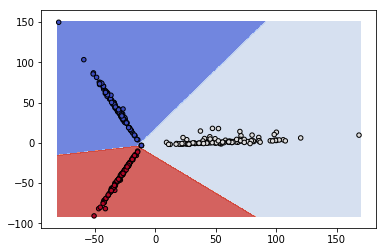

In [117]:
official_plot(xPlot, yPlot)

### Visualizing other results
Actually, 2 dimensions are enough

0.998483699773
0.991166077739


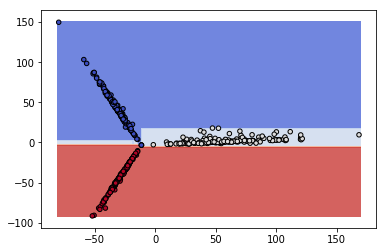

In [132]:
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.03, nthread=4, subsample=0.95, colsample_bytree=0.85, seed=4242)  
# 99.6
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

official_plot(xPlot, yPlot)

#### modified my_plot for high dimension classify with 2d plotting
Gave up as all dimensions need to be considered while computing and plotting. Too much and not able to visualize the result. 

In [ ]:
def make_meshgrid2(x, y, h=.5):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [140]:
def my_plot2(xPlot, yPlot):
    X0, X1 = xPlot[:,0], xPlot[:,1]
    xx, yy = make_meshgrid2(X0, X1)
    Z = clf.predict(xPlot[1:-1,:])
    fig = plt.figure
    plotArray = np.transpose([xx.ravel(), yy.ravel()]);
    colors = [int(i%23) for i in Z]
    plt.scatter(plotArray[:,0], plotArray[:,1], c=colors, s=10, label='Papers',
               alpha=0.3, edgecolors='none')
        
    plt.scatter(X0, X1, c=yPlot, cmap=plt.cm.coolwarm, s=20, edgecolors='k') 
    plt.show()

### Test stops here

0.640636846096
0.681978798587


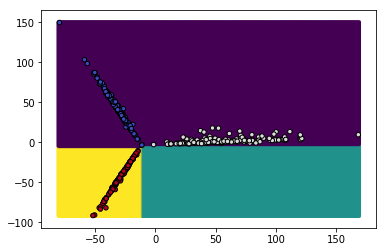

In [147]:
clf = AdaBoostClassifier(n_estimators=350, learning_rate=0.03) #99.8
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

my_plot(xPlot, yPlot)

0.997725549659
0.994699646643


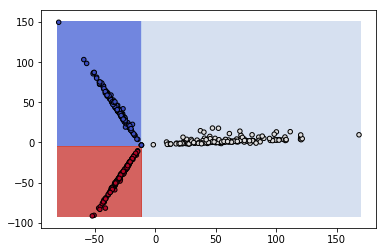

In [148]:
clf = RandomForestClassifier(
        criterion = 'entropy', #gini
        n_estimators=100, 
        max_features=2,
        max_depth = 25,   
        min_samples_split = 20,
        min_samples_leaf = 1,
        n_jobs = 4,
        random_state = 0
       )
# 99.4
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

official_plot(xPlot, yPlot)

### NN classifier

In [149]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1)
clf.fit(xTrain, yTrain)
print clf.score(xTrain, yTrain)
print clf.score(xTest, yTest)

0.996967399545
0.994699646643


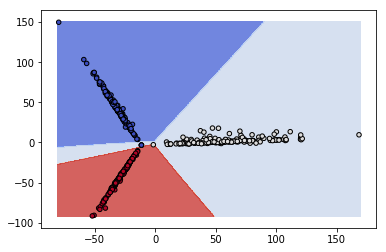

In [151]:
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

official_plot(xPlot, yPlot)

## doc2vec method

In [155]:
import gensim
import os
import collections
import smart_open
import random

In [186]:
def read_docs(abstracts, abstracts2, abstracts3):
    i=0
    for abs in abstracts:
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(abs), [i])
        i=i+1
    for abs in abstracts2:
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(abs), [i])
        i=i+1
    for abs in abstracts3:
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(abs), [i])
        i=i+1
        
train_docs = list(read_docs(abstracts,abstracts2, abstracts3))

In [228]:
model = gensim.models.doc2vec.Doc2Vec(size=5000, min_count=2, iter=55)

In [229]:
model.build_vocab(train_docs)

In [230]:
%time model.train(train_docs, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 13min 9s, sys: 392 ms, total: 13min 9s
Wall time: 4min 23s


10961428

In [192]:
model.docvecs[0]

array([ 1.75257266,  0.06867655, -3.21929216,  0.66062796, -0.51105905,
       -0.6267249 , -0.84704822,  0.23113833,  0.09306807,  0.16651566,
       -0.44596174, -0.39979842, -1.161327  , -1.78691936, -1.51367068,
        0.85768181, -0.78383875, -0.10642561,  0.49693161, -0.5846526 ,
       -0.16415811,  1.97142196, -0.28904086,  0.74239719, -0.20961724,
       -0.64997834,  1.04193532,  0.02229464, -0.46577784, -1.84179282,
       -0.73758388,  0.44296291, -2.43751502,  0.29024154,  1.6378969 ,
       -2.27415252,  1.94515324,  0.01144813, -1.69303846, -1.13842916,
       -0.65794533,  0.4099617 ,  1.27282917, -0.42281899,  0.91167688,
       -0.1344083 ,  0.53366232, -0.90743017,  0.01924414, -0.57321072], dtype=float32)

In [231]:
feature_array_abstract_attached_d2v=[]
for i in range(len(model.docvecs)):
    feature_array_abstract_attached_d2v.append(model.docvecs[i])

labels_attached = np.append(np.append(labels,labels2),labels3) # same as before

### Now go back to PCA and try everything on this feature

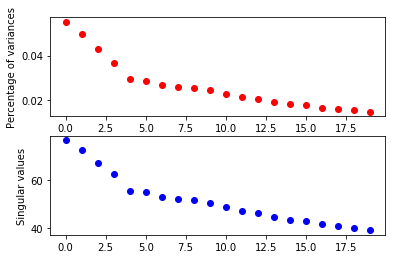

In [232]:
feature_array_abstract_pca = PCA_analysis(feature_array_abstract_attached_d2v, 20)

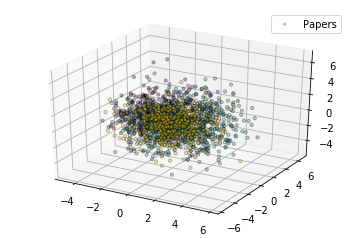

In [233]:
scatter_visualization_3D_with_labels(feature_array_abstract_pca, labels_attached)